In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
pip install optuna

In [16]:
pip install feature-engine

In [17]:
pip install sktime

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
#import cmaes
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
from sklearn.metrics import mean_absolute_error, mean_squared_error
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import ExpandingWindowFeatures,LagFeatures
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sktime.transformations.series.fourier import FourierFeatures
from feature_engine.timeseries.forecasting import WindowFeatures
import holidays
from sklearn.ensemble import RandomForestRegressor


In [19]:
def sliding_window_forecast_fixed_size(modelname, fcst, DF_training_scaled, DF_validation_scaled, scaler_target,
                                       prediction_horizon_steps=96, fixed_training_size=8832):
    """
    Perform a sliding window forecast with a fixed-size training set.

    Parameters:
    fcst (MLForecast): The forecast model.
    DF_training_scaled (pd.DataFrame): Scaled initial training data.
    DF_validation_scaled (pd.DataFrame): Scaled validation data for future predictions.
    scaler_target (MinMaxScaler): Scaler used to inverse transform the target variable.
    prediction_horizon_steps (int): Number of steps ahead to predict (default: 96).
    fixed_training_size (int): Fixed size of the rolling training window.

    Returns:
    pd.DataFrame: A DataFrame containing the day-ahead predictions for each step.
    """
    # Create an empty DataFrame to store all predictions
    all_preds = pd.DataFrame()

    # Sliding window loop: run as long as there are enough validation points left
    num_iterations = len(DF_validation_scaled) // prediction_horizon_steps

    for i in range(num_iterations):
        # Step 1: Fit the model on the current training data (empty static features)
        fcst.fit(DF_training_scaled, static_features=[])

        # Step 2: Predict the next 'prediction_horizon_steps' (e.g., 96 steps)
        # Ensure only the next prediction_horizon_steps rows are passed to X_df
        X_df = DF_validation_scaled.drop(columns=["y"], axis=1).iloc[:prediction_horizon_steps]
        preds = fcst.predict(h=prediction_horizon_steps, X_df=X_df)

        # Step 3: Reshape and inverse transform the predictions to original scale
        predictions_reshaped = preds[modelname].to_numpy().reshape(-1, 1)
        predictions_original_scale = scaler_target.inverse_transform(predictions_reshaped).flatten()

        # Step 4: Assign the predictions to the original DataFrame (store the time index 'ds' and unscaled predictions)
        preds[modelname+"_unscaled"] = predictions_original_scale

        # Step 5: Append predictions to the results DataFrame
        all_preds = pd.concat([all_preds, preds], axis=0)

        # Step 6: Update the training data by appending new validation data
        new_data = DF_validation_scaled.iloc[:prediction_horizon_steps]

        # Remove the newly added data from DF_validation_scaled after each iteration
        DF_validation_scaled = DF_validation_scaled.iloc[prediction_horizon_steps:]

        # Step 7: Maintain a fixed training size by appending new data and dropping the oldest data
        DF_training_scaled = pd.concat([DF_training_scaled, new_data], axis=0)
        if len(DF_training_scaled) > fixed_training_size:
            DF_training_scaled = DF_training_scaled.iloc[-fixed_training_size:]  # Keep only the latest entries

    return all_preds

def plot_predictions(model_name, df_validation_y, all_preds_unscaled):
    plt.figure(figsize=(14, 7))

    # Plot actual values
    plt.plot(df_validation_y.index, df_validation_y.values, label='Actual Values', color='blue', linewidth=2)

    # Plot predicted values
    plt.plot(all_preds_unscaled.index, all_preds_unscaled.values, label=f'Predicted Values ({model_name})', color='red', linestyle='-', linewidth=2)

    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Net Load')
    plt.title(f'Actual vs Predicted Values ({model_name})')

    # Add legend
    plt.legend()

    # Rotate x-ticks for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()

def CreateWorkHourFeature(input_data):
    """
    Receives as input a DataFrame or Series and outputs a DataFrame with the working hours during the day.
    When the day of the week is larger than 4, it is considered a weekend (1), otherwise, it's a workday (0).
    During workdays and between 8:00 and 17:00, it is considered a working hour.

    Parameters:
    input_data (DataFrame or Series): Input data with a DatetimeIndex.

    Returns:
    DataFrame: DataFrame with the added "WorkingHour_flag" column.
    """
    if isinstance(input_data, pd.Series):
        input_df = pd.DataFrame(input_data)
    elif isinstance(input_data, pd.DataFrame):
        input_df = input_data
    else:
        raise ValueError("Input must be a DataFrame or Series.")

    assert isinstance(input_df.index, pd.DatetimeIndex), "Index must be a datetime index."

    input_df["dayOfWeek"] = input_df.index.dayofweek
    input_df.loc[input_df["dayOfWeek"] > 4, "weekendFlag"] = 1
    input_df.loc[input_df["dayOfWeek"] < 5, "weekendFlag"] = 0
    input_df["hour"] = input_df.index.hour
    input_df["WorkingHour_flag"] = 0
    input_df.loc[((input_df["hour"] > 8) & (input_df["hour"] < 17) & (input_df["weekendFlag"] == 0)), "WorkingHour_flag"] = 1
    input_df.drop(["hour", "dayOfWeek", "weekendFlag"], axis=1, inplace=True)

    return input_df


def ListCreatorFlagger(df, substrings=['flag', 'cos', 'sin','day_of_week', 'day_of_month', 'weekend', 'days_in_month', 'hour', 'minute']):
    """
    A function that separates the columns containing specified substrings from those that don't.
    df is the dataframe in question and the substring is a list.
    """
    flag_columns = [col for col in df.columns if any(substring in col for substring in substrings)]

    if not flag_columns:
        print("No columns with the specified substrings found.")
        return None, None

    non_flag_columns = [col for col in df.columns if col not in flag_columns]

    return non_flag_columns, flag_columns


def HolidayFeatureCreator(input_data):
    """
    Receives as input a DataFrame or Series and creates a column named "Holidays_flag" with 1 if there is a holiday and with 0 if no holidays exist.
    Holidays derived from Germany.
    """
    if isinstance(input_data, pd.Series):
        input_df = pd.DataFrame(input_data)
    elif isinstance(input_data, pd.DataFrame):
        input_df = input_data
    else:
        raise ValueError("Input must be a DataFrame or Series.")

    assert isinstance(input_df.index, pd.DatetimeIndex), "Index must be a datetime index."

    national_holidays_all = holidays.DE(years=[2014,2015,2016,2017,2018,2019,2020, 2021, 2022, 2023, 2024, 2025, 2026]).items()
    national_holidays = [items[0] for items in national_holidays_all]  # this is a list

    # Create a new column for holidays flag
    input_df["Holidays_flag"] = 0

    # Iterate over the index and set holiday flag to 1 if the date matches any national holiday
    for index_date in input_df.index:
        if index_date.date() in national_holidays:
            input_df.at[index_date, "Holidays_flag"] = 1

    return input_df




def TimeRelatedFeatureConstructor(df):
  """
  Works only in a dataframe as input: run the other functions first.
  Extracts time-related features
  """
  TimeFeaturesToExtract=["day_of_week","weekend","hour",] #consider to add more
  dtfs=DatetimeFeatures(variables="index", features_to_extract=TimeFeaturesToExtract, drop_original=False)
  df=dtfs.fit_transform(df)

  CyclicalFeaturesToExtract=["day_of_week","hour",]
  cyclical_dtfs=CyclicalFeatures(variables=CyclicalFeaturesToExtract,drop_original=False)
  df=cyclical_dtfs.fit_transform(df)
  return df


def FourierFeatureConstructor(df, granularity, fourier_terms_list):
    # Extract numerical part of granularity
    number_part = ''.join(filter(str.isdigit, granularity))
    number_int = int(number_part) if number_part else 1  # Fallback to 1 to avoid division by zero

    # Calculate minutes per hour, ensuring no division by zero
    minutes4hour = 60 / number_int if number_int != 0 else 60

    # Define seasonal periods (sp_list) for Fourier transformation
    sp_list = [
        max(minutes4hour, 4),                 # Hourly - for 15min, this should be 4
        max(24 * minutes4hour, 96),           # Daily - for 15min, this should be 96
        max(24 * 7 * minutes4hour, 672),      # Weekly - for 15min, this should be 672
        max(24 * 30 * minutes4hour, 2880)     # Monthly - for 15min, this should be 2880
    ]

    # Fourier transformer setup
    Fourier_Transformer = FourierFeatures(
        sp_list=sp_list,
        fourier_terms_list=fourier_terms_list,
        freq=granularity,
        keep_original_columns=True
    )

    # Apply Fourier transformation
    Fourier_Transformer.fit(df)
    df = Fourier_Transformer.transform(df)
    return df



def WindowFeaturesConstructor(df, granularity, ListWithNoFlags):
    """
    This is a function that makes a list of 4 window features starting from double the granularity and following by doubling the previous value
    """
    number_part = ''.join(filter(str.isdigit, granularity))
    number_int = int(number_part)
    double_granularity = 2 * number_int
    time_intervals = [double_granularity]

    # Calculate subsequent values
    for i in range(3):
        time_intervals.append(time_intervals[-1] * 2)

    windowlist = [interval // number_int for interval in time_intervals]  # Corrected division
    functionsList = ["mean", "std"]
    WindownFeatureTransformer = WindowFeatures(variables=ListWithNoFlags,
                                               functions=functionsList,
                                               window=windowlist,
                                               freq=granularity,
                                               drop_original=False)

    df = WindownFeatureTransformer.fit_transform(df)
    return df

def ExpandingWindowFeatureConstructor(df,ListWithNoFlags):
  functionsList=["mean","std"]
  frequency = pd.infer_freq(df.index) #infer the frequency from the dataframe
  ExpandingWindownFeatureTransformer=ExpandingWindowFeatures(variables=ListWithNoFlags,
                                                           functions=functionsList,
                                                           freq=frequency, #I put the freq to shift it down! but now it is performed automatically!
                                                           drop_original=False)
  df=ExpandingWindownFeatureTransformer.fit_transform(df)
  return df

def WeightedLinearFeatureMaker(df,ListWithNoFlags,granularity):
  """
  This is a function that takes the original DF and modifies the continious value columns
  Inputs: Dataframe, List of columns that are continous values, daily window to slide, weights of the values
  """
  number_part = ''.join(filter(str.isdigit, granularity))
  Minutedensity=int(number_part)
  Window=int((60/Minutedensity)*24) #288 means a daily window
  weights=np.arange(1,Window+1)

  # if i had hourly data then i would have had np.arange(1,24*7) for a weekly window

  def weighted_mean (x,weights):
    return (weights*x).sum()/weights.sum()

  def weighted_std(x,weights):
    mean_w= weighted_mean(x, weights)
    var_w= (weights* (x-mean_w)**2).sum()/weights.sum()
    return np.sqrt(var_w)

  # LETS make the weighted mean column
  for i in ListWithNoFlags:
    result=(
        df[i]
        .rolling(window=Window) #here we pick a window size. Needs to be the same as the len(weights)
        .apply(weighted_mean, args=(weights,))
        .shift(1)#shift by 1 to avoid data leakage
        .to_frame()#convert series to df
        )

    result.columns=[str(i)+"_weighted_"+str(Window)+"_mean"]
    df=df.join(result)

  for i in ListWithNoFlags:
    result=(
        df[i]
        .rolling(window=Window) #here we pick a window size. Needs to be the same as the len(weights)
        .apply(weighted_std, args=(weights,))
        .shift(1)#shift by 1 to avoid data leakage
        .to_frame()#convert series to df
        )

    result.columns=[str(i)+"_weighted_"+str(Window)+"_std"]
    df=df.join(result)
  return df

def ExpWeightMeanMaker(df,ListWithNoFlags,granularity):
  """
  This is a function that makes exp weighted average with a sliding window approach
  """
  number_part = ''.join(filter(str.isdigit, granularity))
  Minutedensity=int(number_part)
  Window=int((60/Minutedensity)*24) #288 means a daily window

  def exp_weights(alpha,window_size):
    """
    a function to calculate the weights for every single component of our sliding windown
    """
    weights=np.ones(window_size) #initializing weights
    for ix in range(window_size):
      weights[ix]=(1-alpha)**(window_size-1-ix)
    return weights

  def exp_weighted_mean(x):
    """
    a functions that calculates the exp weigted mean
    """

    weights=exp_weights(alpha=0.05, window_size=len(x)) # HERE WE SET THE ALPHA
    return (weights*x).sum()/weights.sum()

  for i in ListWithNoFlags:
    result=(
        df[i]
        .rolling(window=int(Window))
        .agg([exp_weighted_mean])
        .shift(1)
    )


    result.columns=[str(i)+"_Exp_weighted_"+str(Window)+"_SL.win"]
    df=df.join(result)
  return df

def WeightedExponentialExpandingWindow(df,ListWithNoFlags,alpha):
  """
  This is a funtion that takes as input the df,a list of continuous values and the alpha.
  Outputs: all continuous features on the df that are "mean" and "std"
  """

  for i in ListWithNoFlags:
    df[[str(i)+"_ewm_mean_expanding.win",str(i)+"ewm_std_expanding.win"]]= (
                                              df[i].ewm(alpha=alpha).
                                              agg(["mean","std"])
                                              .shift(1)
                                            )
  return df

def FeatureLagger(df,ListOfFeatures,granularity,PredictionHorizon):

    time_intervals = []
    number_part = ''.join(filter(str.isdigit, granularity))
    Minutedensity=int(number_part)
    end_in_day=int((PredictionHorizon)/(Minutedensity))
    for i in range(1, 1+end_in_day):  # 24 hours * 60 minutes / 15 minutes = 96 intervals
        time_intervals.append(f"{i * 15}min")

    lag_transformer= LagFeatures(variables=ListOfFeatures,
                                freq=time_intervals,
                                drop_original=False) #make a lagger transformer drop all original features

    df=lag_transformer.fit_transform(df) # transform the features to DF joined
    return df


def ErrorCalculator(name, y_true, y_pred):
    errors = {"Pipelines": name,
              "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
              "MAE": mean_absolute_error(y_true, y_pred),
              "MSE": mean_squared_error(y_true, y_pred),

             }
    return errors


def separate_future_past_features(df_columns):
    """
    Separates future and past features from a list of dataframe columns.

    Args:
        df_columns (list): A list of column names from the dataframe.

    Returns:
        dict: A dictionary with keys 'future_features' and 'past_features', containing the respective lists of column names.
    """
    future_keywords = ['sin', 'cos', 'weekend', 'hour', 'holiday', 'minute', 'day','+']

    future_features = []
    past_features = []

    for col in df_columns:
        # Check if the column contains "+" in its name to classify as a past feature
        if any(keyword in col.lower() for keyword in future_keywords):
            future_features.append(col)
        # Columns that don't meet the above conditions are considered past features by default
        else:
            past_features.append(col)

    return future_features, past_features


def plot_errors (ErrorSeries):
  """
  This is a function that plots the features that are not
  """
  import matplotlib as mpl
  import matplotlib.pyplot as plt
  import matplotlib.path as mpath
  import numpy as np

  import matplotlib.pyplot as plt
  import numpy as np

  x = np.arange(len(ErrorSeries.index))
  y = ErrorSeries.values
  labels = ErrorSeries.index

  plt.figure(1,figsize=(13,5))
  plt.style.use("seaborn-v0_8-whitegrid")
  plt.plot(x, y)

  plt.xticks(x, labels, rotation =40)
  plt.ylabel('RMSE [€/MWh]', wrap=True)
  plt.xlabel('Features', wrap=True)


  plt.margins(0.05)

  plt.subplots_adjust(bottom = 0.05)
  plt.show()


def select_features_minimum_plus_others(series):
    """
    Takes a pandas Series and selects the features that:
    - Include all features up to the minimum error.
    - After the minimum error, only include features that reduce the error compared to the previous one.
    - Ensures no duplicate features are added.

    Parameters:
    - series: A pandas Series where index are feature names and values are errors.

    Returns:
    - A list of selected feature names without duplicates.
    """
    # Find the index of the minimum value
    min_idx = series.idxmin()

    # Select all features up to and including the minimum
    selected_features = list(dict.fromkeys(series[:min_idx].index.tolist() + [min_idx]))

    # After the minimum, keep only the features that decrease the error
    after_min_series = series[min_idx:]

    # Loop through the series after the minimum value and add features that decrease the error
    for i in range(1, len(after_min_series)):
        if after_min_series[i] < after_min_series[i - 1]:
            feature = after_min_series.index[i]
            if feature not in selected_features:
                selected_features.append(feature)

    return selected_features

def keep_indices_till_min(series):
    """
    Keeps all index values from the series up to and including the minimum value using a for loop,
    while ensuring no duplicates are added.

    Parameters:
    - series: A pandas Series where the index are feature names and the values are errors.

    Returns:
    - A list of unique index values (features) up to and including the minimum error value.
    """
    # Initialize an empty list to store the selected indices
    selected_features = []

    # Find the minimum value in the series
    min_value = series.min()

    # Loop over the series
    for idx, value in series.items():
        # Add the current index to the selected features only if it's not already present
        if idx not in selected_features:
            selected_features.append(idx)

        # If the current value is the minimum, stop the loop
        if value == min_value:
            break

    return selected_features

def laggedColumnCreator(df,columnName,lagStart, lagInterval, lagEnd):
  for i in range(lagStart, lagEnd+1, lagInterval):
     newColumnName = columnName + "-" + str(i) + "step" #you gotta put it in string
     df[newColumnName] = df[columnName].shift(i)
  return df


def make_splits(
    test_start_str: str,
    freq: str = "15min",      # your timestep
    val_days: int = 14,
    train_steps: int = 7000,
    test_days: int = 14,       # length of test period
):
    step = pd.to_timedelta(freq)

    # TEST
    test_start = pd.Timestamp(test_start_str)
    # If you slice df.loc[start:end] (inclusive), use -step to get exactly `test_days` worth of data
    test_end = test_start + pd.Timedelta(days=test_days)

    # VALIDATION (ends one step before test_start)
    validation_end = test_start - step
    # `val_days` long, inclusive: end - start = val_days days - step
    validation_start = validation_end - pd.Timedelta(days=val_days) + step

    # TRAIN (ends one step before validation_start)
    train_end = validation_start - step
    # exactly `train_steps` steps long: end - start = (train_steps - 1) * step
    train_start = validation_start - train_steps * step

    return {
        "train_start": train_start,
        "train_end": train_end,
        "validation_start": validation_start,
        "validation_end": validation_end,
        "test_start": test_start,
        "test_end": test_end,
    }


def FeatureSelection(regressor, DF_features, DF_target, ordered_features_list, test_size=672, tolerance=400):
    """
    This function receives a regressor model, the features that the model was trained with,
    and the target that it had to forecast. Starting from the most important feature,
    we find the error of the TimeSeries Cross-Validation with a fixed test size.
    By adding features, we find the new error of the forecast.

    Parameters:
    - regressor: The regression model to use for training and prediction.
    - DF_features: DataFrame containing the features.
    - DF_target: Series containing the target variable.
    - ordered_features_list: List of features ordered by importance (e.g., from SHAP analysis).
    - test_size: Number of steps to use in the test set (default is 672).
    - tolerance: Number of features to add before stopping if no improvement in error (default is 20).

    Returns:
    - ErrorSeries: A pandas Series with the errors for each step of feature addition.
    """

    feature_list = []  # Empty list of features
    error_list = []  # Empty list to store errors for each set of features
    total_samples = len(DF_features)  # Total number of samples in the dataset
    n_splits = 5  # Number of splits (fixed)
    no_improvement_count = 0  # Count features added without improvement
    min_error = float('inf')  # Start with a large error to track the minimum error

    for i in ordered_features_list:
        # Start the loop with the best feature and append the next ones
        feature_list.append(i)

        X = DF_features[feature_list].to_numpy()
        y = DF_target.to_numpy()

        #print(f"Performing feature selection with features: {feature_list}")

        # Custom logic to create splits with a fixed test size of 672
        splits = []
        start_train_size = total_samples - (n_splits * test_size)  # Calculate where to start training

        for split in range(n_splits):
            train_end = start_train_size + split * test_size
            test_start = train_end
            test_end = test_start + test_size

            if test_end <= total_samples:  # Ensure the test set is within the bounds
                splits.append((list(range(0, train_end)), list(range(test_start, test_end))))

        TimeSeriesCVerror = []  # MSE errors for each fold

        # Time series cross-validation with fixed test size
        for train_index, test_index in splits:
            #print(f"TRAIN: {train_index}, TEST: {test_index}")
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Train the regressor and predict
            regressor.fit(X_train, y_train)
            predicted_val = regressor.predict(X_test)

            # Calculate the error for this fold
            Error = np.sqrt(mean_squared_error(y_test, predicted_val))
            TimeSeriesCVerror.append(Error)
            #print(f"This is the error for one TS iteration: {Error}")

        # Calculate the average error across all splits
        TS_CV_error = sum(TimeSeriesCVerror) / len(TimeSeriesCVerror)
        #print(f"Cumulative error of the last steps: {TS_CV_error}")
        error_list.append(TS_CV_error)  # Store the error for this set of features

        # Check if the error improved
        if TS_CV_error < min_error:
            min_error = TS_CV_error  # Update the minimum error
            no_improvement_count = 0  # Reset the no-improvement count
        else:
            no_improvement_count += 1  # Increment if there's no improvement

        # Break the loop if no improvement is observed after 20 features
        if no_improvement_count >= tolerance:
            print(f"No improvement after {tolerance} features. Stopping early.")
            break

    # Create a pandas Series to store the error associated with each feature
    ErrorSeries = pd.Series(error_list, index=feature_list)

    # Plot the errors using a custom plot function
    plot_errors(ErrorSeries)

    return ErrorSeries

# start

In [20]:
filename="NO2_price_10min_2024_2025.xlsx"
#define the path of the folder with the data
path="/content/gdrive/MyDrive/IEEE-EEM2026/"
#join the folder with the name of the file I want to study

df = pd.read_excel(os.path.join(path,filename), parse_dates=[0]).set_index('timestamp')
df = df[~df.index.duplicated(keep='first')] # Drop duplicate timestamps before setting frequency
df = df.asfreq('10min') # Set the frequency of the index

OriginalFeatures=df.columns.to_list()

df["target"]=df["NO2 price (NOK/kWh)"]
target="target"

OutputPath = r"C:\Users\User\Desktop\_badenova_forecaster\outputs"

granularity="10min"
prediction_horizon="1440min"

number_part_hor = ''.join(filter(str.isdigit, prediction_horizon))
PredictionHorizon=int(number_part_hor)
number_part = ''.join(filter(str.isdigit, granularity))
Minutedensity=int(number_part)
fourier_terms_list=[2,2,2,2]
prediction_horizon_steps=PredictionHorizon//Minutedensity # this is 96
print("this is the prediction horizon in steps", prediction_horizon_steps)
# lets make some features
lagStart = prediction_horizon_steps          # Start lagging from 1 step
lagInterval = 1       # Interval of 1 step
lagEnd = prediction_horizon_steps *2

for feature in OriginalFeatures:
    df = laggedColumnCreator(df, feature, lagStart, lagInterval, lagEnd)
#lets build the target and the features
df=HolidayFeatureCreator(df)
df=CreateWorkHourFeature(df)
df=TimeRelatedFeatureConstructor(df)
df=FourierFeatureConstructor(df,granularity,fourier_terms_list)

df=df.drop(columns=OriginalFeatures)

df.dropna(inplace=True)

this is the prediction horizon in steps 144


/tmp/ipython-input-2329344273.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[newColumnName] = df[columnName].shift(i)
/tmp/ipython-input-2329344273.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[newColumnName] = df[columnName].shift(i)
/tmp/ipython-input-2329344273.py:482: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

In [21]:
#test_date="2025-06-01 00:00:00" #summer
test_date="2025-02-01 00:00:00" #winter


# Example
splits = make_splits(test_date, freq="10min", val_days=14, train_steps=5000)

train_start=splits["train_start"]
train_end=splits["train_end"]
validation_start=splits["validation_start"]
validation_end=splits["validation_end"]
test_start=splits["test_start"]
test_end =splits["test_end"]

#lets split them
DF_training = df[train_start:train_end]  # Include up to train_end_date
DF_validation = df[validation_start:validation_end]  # Start after train_end_date
DF_test = df[test_start:test_end]  # Start after validation_end_date


DF_training_and_DF_validation=pd.concat([DF_training,DF_validation])
Selected_Features=DF_training_and_DF_validation.drop([target],axis=1) # df, all features except target in a dataframe for the first period
DF_target=DF_training_and_DF_validation[target] #one column df of the target for the next period


In [22]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor # Changed from LassoLars

# Define features (X) and target (y)
X = Selected_Features
y = DF_target

# Initialize LassoLars
model = RandomForestRegressor() # Changed model and added max_iter for convergence

# Initialize TimeSeriesSplit
# n_splits determines the number of train/test splits to generate.
# Each split's training set grows, and its test set is a fixed size (the last part of the data).
# For example, if n_splits=5, there will be 5 splits.
# The first split might use 20% for train, 20% for test, and the last uses 80% for train, 20% for test.
tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []

# Perform Time Series Cross-Validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate RMSE and store it
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

print(f"RMSE scores for each fold: {rmse_scores}")
print(f"Average RMSE across all folds: {np.mean(rmse_scores)}")

RMSE scores for each fold: [np.float64(0.18487203985542502), np.float64(0.5698731375567002), np.float64(0.715485316786393), np.float64(1.3916120553932194), np.float64(0.4987366441476252)]
Average RMSE across all folds: 0.6721158387478725


In [23]:
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor # Changed from LassoLars

def objective(trial):
    # 3. Suggest hyperparameters for RandomForestRegressor
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500), # Number of trees in the forest
        'max_depth': trial.suggest_int('max_depth', 5, 50), # Maximum depth of the tree
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20), # Minimum number of samples required at each leaf node
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20), # Minimum number of samples required to split an internal node
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 1.0]), # Number of features to consider when looking for the best split
        'random_state': 42 # For reproducibility
    }

    # 4. Initialize a RandomForestRegressor model using the suggested hyperparameters
    model = RandomForestRegressor(**param) # Changed model

    # 5. Instantiate TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # 6. Initialize an empty list to store RMSE scores for each fold
    rmse_scores = []

    # Use the globally available X (Selected_Features) and y (DF_target)
    X = Selected_Features
    y = DF_target

    # 7. Loop through the splits generated by TimeSeriesSplit
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # 8. Train the model and make predictions
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # 9. Calculate RMSE for each fold and append it to the rmse_scores list
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)

    # 10. Calculate the mean of the rmse_scores
    mean_rmse = np.mean(rmse_scores);

    # 11. Return the calculated mean RMSE
    return mean_rmse

print("Optuna objective function 'objective' defined successfully.")

Optuna objective function 'objective' defined successfully.


In [24]:
import joblib
import optuna
from sklearn.ensemble import RandomForestRegressor # Added for final model

# 1. Create an Optuna study
# Using a TPE sampler with a seed for reproducibility
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)

# 2. Run the optimization process
# You can adjust n_trials based on computational resources and desired exploration
print("Starting Optuna optimization...")
study.optimize(objective, n_trials=20, show_progress_bar=True)
print("Optuna optimization finished.")

# 3. Print the best trial's value and parameters
print("\nBest trial:")
trial = study.best_trial
print(f"  Value (Mean RMSE): {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# 4. Retrieve the best hyperparameters from the Optuna study
best_params = study.best_params

# 5. Train a final RandomForestRegressor model with the best parameters
print("\nTraining final RandomForestRegressor model with best parameters...")
final_model = RandomForestRegressor(**best_params, random_state=42) # Changed from LassoLars

X_train=DF_training_and_DF_validation.drop([target],axis=1) # df, all features except target in a dataframe for the first period
X_test=DF_test.drop([target],axis=1) #df , all feature except target (same as before but for the next available period period)
y_train=DF_training_and_DF_validation[target] #one column df, of the target for the first period
y_test=DF_test[target] #one column df of the target for the next period


final_model.fit(X_train , y_train)

predicted_val = final_model.predict(X_test)

name="RandomForestRegressor" # Changed model name
d=ErrorCalculator(name,y_test,predicted_val)
print(d)

[I 2026-01-21 13:47:56,474] A new study created in memory with name: no-name-bf83d94d-00bd-42db-a625-e1016f1f7497


Starting Optuna optimization...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-01-21 13:48:23,463] Trial 0 finished with value: 0.624958866172141 and parameters: {'n_estimators': 218, 'max_depth': 48, 'min_samples_leaf': 15, 'min_samples_split': 13, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.624958866172141.
[I 2026-01-21 13:49:17,472] Trial 1 finished with value: 0.6268791972152595 and parameters: {'n_estimators': 440, 'max_depth': 32, 'min_samples_leaf': 15, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.624958866172141.
[I 2026-01-21 13:52:41,131] Trial 2 finished with value: 0.6687290002019745 and parameters: {'n_estimators': 132, 'max_depth': 13, 'min_samples_leaf': 7, 'min_samples_split': 11, 'max_features': 1.0}. Best is trial 0 with value: 0.624958866172141.
[I 2026-01-21 13:52:56,407] Trial 3 finished with value: 0.6267338312677646 and parameters: {'n_estimators': 112, 'max_depth': 18, 'min_samples_leaf': 8, 'min_samples_split': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.624958866172141.

<Axes: xlabel='timestamp'>

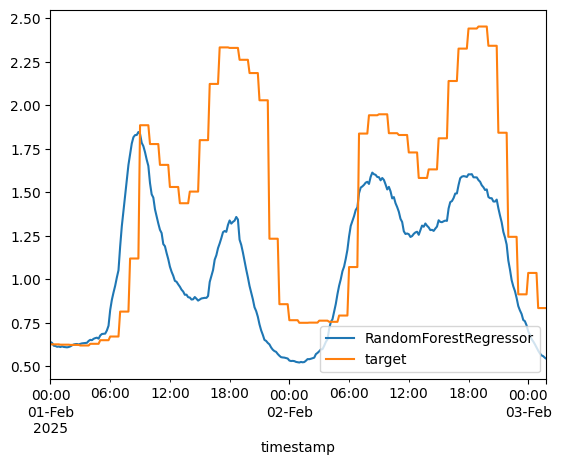

In [25]:
predicted_DF = pd.DataFrame(predicted_val , index=DF_test.index, columns=["RandomForestRegressor"]) # Changed column name

predicted_DF = predicted_DF.join(y_test)

predicted_DF=predicted_DF.loc[DF_test.index]

predicted_DF.columns = ["RandomForestRegressor", "target"]


predicted_DF[:300].plot()

In [26]:
# Ensure it's a Timestamp / datetime
test_date_ts = pd.to_datetime(test_date)

# Format without forbidden chars (:, etc.)
test_date_str = test_date_ts.strftime("%Y-%m-%d_%H-%M-%S")  # e.g. 2025-09-19_00-00-00

test_ts = f"{test_date_str}_RandomForestRegressor.csv" # Changed file name
test_filepath = os.path.join(path, test_ts)

predicted_DF["RandomForestRegressor"].to_csv(test_filepath, index=True) # Changed column name